In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

%matplotlib inline

In [93]:
# !pip install gensim==3.0.0

In [94]:
# !pip install scipy==1.0.0

In [95]:
df = pd.read_csv("data/processed/test.csv")
df.head()
df.columns

Index(['Unnamed: 0', 'cid', 'smiles', 'action'], dtype='object')

In [96]:
import gensim
gensim.__version__

'3.0.0'

In [97]:
# remove null values
df = df[~df["action"].isnull()]

In [98]:
df['action'].value_counts()

AGONIST            108
ANTAGONIST          57
FULL AGONIST        19
PARTIAL AGONIST     14
POSITIVE             4
BINDER               2
NEUTRAL              2
BIASED AGONIST       2
OTHER/UNKNOWN        1
LIGAND               1
Name: action, dtype: int64

In [99]:
def parse(x):
    x = str(x)
    if x.startswith("FULL "):
        return "AGONIST"
    else:
        return x
        
df["action_gen"] = df["action"].apply(parse)
df["action_gen"].value_counts()

AGONIST            127
ANTAGONIST          57
PARTIAL AGONIST     14
POSITIVE             4
BINDER               2
NEUTRAL              2
BIASED AGONIST       2
OTHER/UNKNOWN        1
LIGAND               1
Name: action_gen, dtype: int64

In [100]:
condition = (df.action_gen != "AGONIST") & (df.action_gen != "ANTAGONIST") & (df.action_gen != "PARTIAL AGONIST")
df["action_gen"] = np.where(condition, "OTHER", df.action_gen)
df["action_gen"].value_counts()

AGONIST            127
ANTAGONIST          57
PARTIAL AGONIST     14
OTHER               12
Name: action_gen, dtype: int64

In [101]:
df = df.drop_duplicates(subset=['cid'])
df = df[['cid', 'smiles', 'action', 'action_gen']]
df.set_index('cid', inplace=True)
df.to_csv('data/processed/basic_data.csv')

In [102]:
df.shape

(171, 3)

In [103]:
print(">>> create mol from smiles ... ")
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 

print(">>> create sentence from mol ... ")
df['sentence'] = df.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], radius=1)), axis=1)

print(">>> load the word2vec model ... ")
from gensim.models import word2vec
w2v_model = word2vec.Word2Vec.load('model\\model_300dim.pkl')
# w2v_model = word2vec.Word2Vec.load('model_300dim.pkl')

print(">>> create embedding from sentence ... ")
df['embedding'] = [DfVec(x) for x in sentences2vec(df['sentence'], w2v_model)]

print(">>> data columns = ", df.columns, "\n")

df_mol2vec = np.array([x.vec for x in df['embedding']])
df_mol2vec = pd.DataFrame(df_mol2vec)


>>> create mol from smiles ... 
>>> create sentence from mol ... 
>>> load the word2vec model ... 
>>> create embedding from sentence ... 
>>> data columns =  Index(['smiles', 'action', 'action_gen', 'mol', 'sentence', 'embedding'], dtype='object') 



In [104]:
df_mol2vec

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,1.760172,-4.149978,-3.370153,2.645751,1.110236,-0.118626,-11.081466,-0.428177,5.755222,2.341738,...,2.786106,11.721737,8.545668,-1.289715,-9.153688,-3.488175,-7.180833,-3.843996,-12.202745,-3.068497
1,2.212945,-1.538977,-2.224593,4.679339,1.052032,0.276928,-8.678493,2.908898,4.829803,2.057426,...,-1.862839,9.285961,7.572005,1.240420,-8.727465,-2.931877,-4.774791,-3.370778,-7.536181,-1.402127
2,-1.224218,-1.380079,-1.484625,2.016409,2.085845,-0.418231,-10.214646,0.171975,5.722785,-0.639067,...,0.040365,9.228453,8.112383,0.192953,-8.544584,-4.927303,-3.219604,-6.842189,-7.540254,-4.475022
3,1.051206,-4.003702,-2.004881,6.037580,1.132930,-0.998191,-10.552450,0.181484,8.399479,1.503116,...,-1.705281,12.330570,9.170075,1.122113,-7.963986,-2.675577,-4.884267,-4.236066,-10.162477,-1.244159
4,0.159625,-1.877022,-0.894390,4.311310,-2.904269,-0.823098,-5.099559,1.956799,5.010140,3.007601,...,0.054925,8.062354,4.741454,-0.126390,-7.416485,-2.226036,-3.864702,-2.264680,-3.720523,-1.077843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,2.558320,-7.041398,-1.867085,8.540926,-1.992054,-1.297663,-11.814894,1.890232,9.369178,4.298574,...,-0.418635,14.808561,6.444794,-1.048025,-10.536049,-2.944379,-6.397175,-4.665662,-9.163932,-0.410053
167,2.268912,-6.673174,-1.812337,8.857821,-2.151901,-1.198620,-11.679358,2.329433,9.370055,4.481280,...,-0.245198,14.701890,6.460775,-1.099652,-10.371346,-2.524029,-5.959694,-5.040211,-8.999833,-0.545627
168,0.619165,-3.699804,-3.688030,1.413995,1.368354,-6.651547,-13.590994,2.757429,3.370274,2.640249,...,-2.574120,15.301981,6.480038,1.606085,-12.458905,-10.682524,-8.736527,-5.380240,-16.338335,1.824793
169,6.181717,-8.531713,-4.172251,7.466651,-0.264419,1.975113,-12.068586,-1.140604,3.199877,1.405521,...,-0.677975,15.115541,8.754032,-5.851270,-11.648660,-6.113319,-11.374367,-5.213731,-13.194325,-3.314379


In [105]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder


In [106]:
# add indexes to dictionary
df.reset_index(inplace=True)
# encoding
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()
# df['encoded_label'] = labelencoder.fit_transform(df['action_gen'])
df

,cid,smiles,action,action_gen,mol,sentence,embedding
0,2159,CCN1CCCC1CNC(=O)C2=CC(=C(C=C2OC)N)S(=O)(=O)CC,AGONIST,AGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 225184566...","(300,) dimensional vector"
1,2160,CN(C)CCC=C1C2=CC=CC=C2CCC3=CC=CC=C31,BINDER,OTHER,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3818546315, 848128881, 3121777292...","(300,) dimensional vector"
2,2562,CCN(CC)CCOCCOC(=O)C1(CCCC1)C2=CC=CC=C2,ANTAGONIST,ANTAGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 592593828...","(300,) dimensional vector"
3,3345,CCC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3,AGONIST,AGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 206478835...","(300,) dimensional vector"
4,3821,CNC1(CCCCC1=O)C2=CC=CC=C2Cl,BINDER,OTHER,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3824063894, 847961216, 1733418522...","(300,) dimensional vector"
...,...,...,...,...,...,...,...
166,132990963,C1CCC(CC1)N2CCN(CC2)C(CC3=CC=CC=C3)C4=CC=C(C=C4)F,AGONIST,AGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2968968094, 2142032900, 2968968094, 214203290...","(300,) dimensional vector"
167,132990975,C1CCC(CC1)N2CCN(CC2)C(CC3=CC=CC=C3)C4=CC=CC=C4F,AGONIST,AGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2968968094, 2142032900, 2968968094, 214203290...","(300,) dimensional vector"
168,134156377,CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)OC)O[C...,AGONIST,AGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3657471097, 2092489639, 201425559...","(300,) dimensional vector"
169,137434175,CCC1=CC2=C(C(=C(N=C2C(=C1)F)N3CCC(CC3)NC4CCOCC...,ANTAGONIST,ANTAGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 618671879...","(300,) dimensional vector"


In [107]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import rand_score

In [108]:
# scaler = StandardScaler()
# df_mol2vec = scaler.fit_transform(df_mol2vec)

# scaler = MinMaxScaler()
# df_mol2vec = scaler.fit_transform(df_mol2vec)


1.0000000100614177


c:\Users\fongm\Anaconda3\envs\m2vec\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


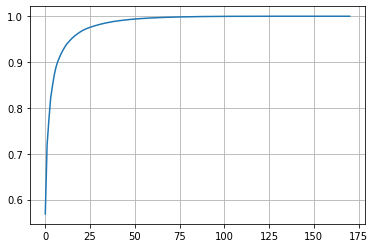

In [109]:
scaler = StandardScaler()
df_mol2vec_scaled = scaler.fit_transform(df_mol2vec)

pca = PCA().fit(df_mol2vec_scaled)
pc = pca.transform(df_mol2vec_scaled)

var = pca.explained_variance_ratio_[:10]
cum_sum = np.cumsum(pca.explained_variance_ratio_)
labels = ['PC'+ str(i) for i in range(1,11)]

print(sum(pca.explained_variance_ratio_))
# sns.barplot(labels, var)
sns.lineplot([x for x in range(len(cum_sum))], cum_sum)
plt.grid()
plt.show()

## TSNE 2 dim

c:\Users\fongm\Anaconda3\envs\m2vec\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\fongm\Anaconda3\envs\m2vec\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


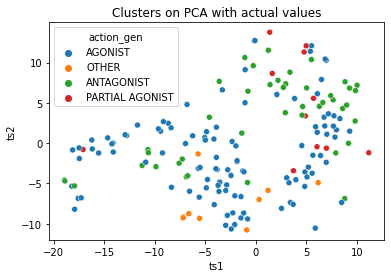

In [110]:
np.random.seed(42)

scaler = StandardScaler()
df_mol2vec_scaled = scaler.fit_transform(df_mol2vec)
pca_num_components = 5

# reduced_data = PCA(n_components=pca_num_components).fit_transform(df_mol2vec_scaled)
# results = pd.DataFrame(reduced_data,columns=['pc' + str(x) for x in range(1, pca_num_components + 1)])

tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_mol2vec)

tsne_results = pd.DataFrame(tsne_results, columns=['ts1', 'ts2'])
sns.scatterplot(x='ts1', y="ts2", hue=df['action_gen'], data=tsne_results)
plt.title('Clusters on PCA with actual values')
plt.show()

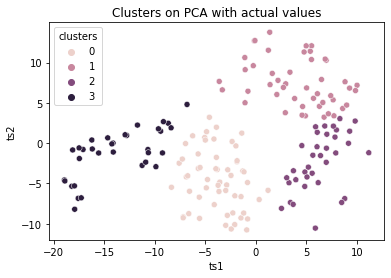

In [111]:
clustering_kmeans = KMeans(n_clusters=4)
tsne_results['clusters'] = clustering_kmeans.fit_predict(tsne_results)
tsne_results['clusters']

sns.scatterplot(x='ts1', y="ts2", hue=tsne_results['clusters'], data=tsne_results)
plt.title('Clusters on PCA with actual values')
plt.show()

In [112]:
print(tsne_results['clusters'].value_counts())
cluster_dict = dict(tsne_results['clusters'].value_counts())
cluster_dict = dict(sorted(cluster_dict.items(), key=lambda item: item[1], reverse=True)).keys()
cluster_dict = list(cluster_dict)

tsne_results['action_gen'] = df['action_gen']
tsne_results['action_gen_cluster'] = tsne_results['clusters'].map({cluster_dict[0]: 'AGONIST', cluster_dict[1]: 'ANTAGONIST', cluster_dict[2]: 'ANTAGONIST', cluster_dict[3]: 'OTHER'})

print('pairing_score: ', rand_score(tsne_results.action_gen, tsne_results.action_gen_cluster))
tsne_results[tsne_results.action_gen == tsne_results.action_gen_cluster].shape[0] / tsne_results.shape[0]
print('Accuracy', tsne_results[tsne_results.action_gen == tsne_results.action_gen_cluster].shape[0] / tsne_results.shape[0])

0    56
1    47
2    35
3    33
Name: clusters, dtype: int64
pairing_score:  0.5076023391812865
Accuracy 0.4093567251461988


## LDA

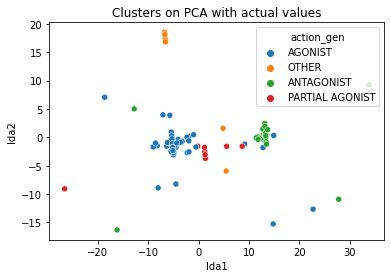

In [162]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split

np.random.seed(42)
df_mol2vec_scaled = df_mol2vec
scaler = StandardScaler()
df_mol2vec_scaled = pd.DataFrame(scaler.fit_transform(df_mol2vec))
df_mol2vec_scaled['action_gen'] = df['action_gen']


# normal LDA 
n_comp = 2
# lda = LDA(n_components=n_comp).fit(df_mol2vec_scaled.iloc[:, :-1], df_mol2vec_scaled.iloc[:, -1])

# normal LDA with partial training set to prevent overfitting
# df_sample = df_mol2vec_scaled.sample(n=130)
# lda = LDA(n_components=n_comp).fit(df_sample.iloc[:, :-1], df_sample.iloc[:, -1])
X_train, X_test, y_train, y_test = train_test_split(df_mol2vec_scaled.iloc[:, :-1], df_mol2vec_scaled.iloc[:, -1], 
                                                train_size=0.85, random_state=42)
lda = LDA(n_components=n_comp).fit(X_train, y_train)

# solve generalized eigenvalue problem
# X_train, X_test, y_train, y_test = train_test_split(df_mol2vec_scaled.iloc[:, :-1], df_mol2vec_scaled.iloc[:, -1], 
#                                                 train_size=0.6, random_state=42)
# lda = LDA(n_components=n_comp, solver='eigen', shrinkage=0.2).fit(X_train, y_train)

df_mol2vec_scaled.drop("action_gen", axis=1, inplace=True)
lda_results = lda.transform(df_mol2vec_scaled)
# lda_results = lda.transform(X_test)

lda_results = pd.DataFrame(lda_results, columns=['lda' + str(i) for i in range(1, n_comp+1)])
# sns.scatterplot(x='lda1', y="lda2", hue=y_test, data=lda_results)
sns.scatterplot(x='lda1', y="lda2", hue=df['action_gen'], data=lda_results)
plt.title('Clusters on PCA with actual values')
plt.show()

In [163]:
print('pairing_score: ', rand_score(y_test, lda.predict(X_test)))
print(classification_report(y_test, lda.predict(X_test)))

pairing_score:  0.6123076923076923
                 precision    recall  f1-score   support

        AGONIST       0.80      0.71      0.75        17
     ANTAGONIST       0.25      0.40      0.31         5
          OTHER       0.00      0.00      0.00         2
PARTIAL AGONIST       0.00      0.00      0.00         2

       accuracy                           0.54        26
      macro avg       0.26      0.28      0.26        26
   weighted avg       0.57      0.54      0.55        26



c:\Users\fongm\Anaconda3\envs\m2vec\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fongm\Anaconda3\envs\m2vec\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fongm\Anaconda3\envs\m2vec\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [117]:
lda.transform(df_mol2vec.iloc[50:51, :])

array([[12.70073285,  2.68483366]])

In [164]:
clustering_kmeans = KMeans(n_clusters=4)
lda_results['clusters'] = clustering_kmeans.fit_predict(lda_results)
# lda_results['clusters'].value_counts()

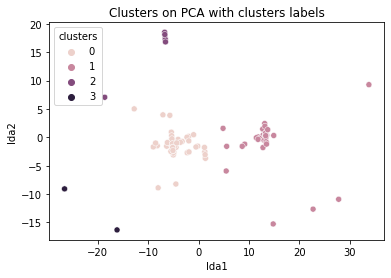

In [165]:
sns.scatterplot(x="lda1", y="lda2", hue=lda_results['clusters'], data=lda_results)
plt.title('Clusters on PCA with clusters labels')
plt.show()

In [167]:
print(lda_results['clusters'].value_counts())
# sort keys based on number of values in each clusters
cluster_dict = dict(lda_results['clusters'].value_counts())
cluster_dict = dict(sorted(cluster_dict.items(), key=lambda item: item[1], reverse=True)).keys()
cluster_dict = list(cluster_dict)

lda_results['action_gen'] = df['action_gen']
lda_results['action_gen_cluster'] = lda_results['clusters'].map({cluster_dict[0]: 'AGONIST', cluster_dict[1]: 'ANTAGONIST', cluster_dict[2]: 'PARTIAL AGONIST', cluster_dict[3]: 'OTHER'})

print('pairing_score: ', rand_score(lda_results.action_gen, lda_results.action_gen_cluster))
lda_results[lda_results.action_gen == lda_results.action_gen_cluster].shape[0] / lda_results.shape[0]
# print('Accuracy', accuracy_score(lda_results.action_gen, lda_results.action_gen_cluster))
print(classification_report(lda_results.action_gen, lda_results.action_gen_cluster))


0    112
1     49
2      8
3      2
Name: clusters, dtype: int64
pairing_score:  0.8481596147230822
                 precision    recall  f1-score   support

        AGONIST       0.91      0.94      0.93       108
     ANTAGONIST       0.82      0.93      0.87        43
          OTHER       0.00      0.00      0.00         9
PARTIAL AGONIST       0.00      0.00      0.00        11

       accuracy                           0.83       171
      macro avg       0.43      0.47      0.45       171
   weighted avg       0.78      0.83      0.80       171



In [121]:
c_rpt = classification_report(lda_results.action_gen, lda_results.action_gen_cluster, output_dict=True)
total_score = sum([c_rpt[key]['precision'] for key in list(c_rpt.keys())[:4]])

In [122]:
df.action_gen.value_counts()/df.shape[0]

AGONIST            0.631579
ANTAGONIST         0.251462
PARTIAL AGONIST    0.064327
OTHER              0.052632
Name: action_gen, dtype: float64